In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster,MarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly.graph_objs as go
import plotly.plotly as py 
from plotly.offline import iplot, init_notebook_mode

# using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [97]:
from IPython.display import display

In [32]:
listings = pd.read_csv('listings.csv')

In [33]:
listings.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,2.10,1,44
1,3209,"Quiet apt near center, great view",3806,Maartje,NaN,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,2018-08-29,1.03,1,47
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,NaN,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,2018-11-30,2.18,2,198


In [34]:
listings_details = pd.read_csv('listings_details.csv',low_memory=False)
listings_details.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20181206172549,2018-12-06,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,f,NaN,{Amsterdam},t,f,strict_14_with_grace_period,f,f,1,2.10
1,3209,https://www.airbnb.com/rooms/3209,20181206172549,2018-12-06,"Quiet apt near center, great view",You will love our spacious (90 m2) bright apar...,"Our apartment has lots of light, a balcony and...",You will love our spacious (90 m2) bright apar...,none,Welcome to the Spaarndammerbuurt! From the beg...,...,f,NaN,{Amsterdam},f,f,moderate,f,f,1,1.03
2,20168,https://www.airbnb.com/rooms/20168,20181206172549,2018-12-06,100%Centre-Studio 1 Private Floor/Bathroom,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,...,f,NaN,{Amsterdam},f,f,strict_14_with_grace_period,f,f,2,2.18


In [35]:
listings_details.shape

(20030, 96)

In [36]:
listings.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [37]:
target_columns = ["id", "property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "street", "weekly_price", "monthly_price", "market"]
listings = pd.merge(listings, listings_details[target_columns], on = 'id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 0 to 20029
Data columns (total 36 columns):
id                                20030 non-null int64
name                              19992 non-null object
host_id                           20030 non-null int64
host_name                         20026 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     20030 non-null object
latitude                          20030 non-null float64
longitude                         20030 non-null float64
room_type                         20030 non-null object
price                             20030 non-null int64
minimum_nights                    20030 non-null int64
number_of_reviews                 20030 non-null int64
last_review                       17624 non-null object
reviews_per_month                 17624 non-null float64
calculated_host_listings_count    20030 non-null int64
availability_365                  20030 non-null int64
pr

In [38]:
listings = listings.drop(columns=['neighbourhood_group'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))
listings.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,...,15,https://www.airbnb.com/rooms/2818,t,"Upon arriving in Amsterdam, one can imagine as...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam
1,3209,"Quiet apt near center, great view",3806,Maartje,Westerpark,52.390225,4.873924,Entire home/apt,160,4,...,20,https://www.airbnb.com/rooms/3209,f,I am a freelance radio producer and journalist...,within an hour,100.0,"Amsterdam, Noord-Holland, Netherlands",$543.00,"$2,000.00",Amsterdam
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,...,1000,https://www.airbnb.com/rooms/20168,f,Secondary phone nr. + (Phone number hidden by ...,within a few hours,100.0,"Amsterdam, North Holland, Netherlands",NaN,NaN,Amsterdam
3,25428,Lovely apt in City Centre (Jordaan),56142,Joan,Centrum-West,52.373114,4.883668,Entire home/apt,125,14,...,60,https://www.airbnb.com/rooms/25428,f,"We are a retired couple who live in NYC, and h...",within a few hours,100.0,"Amsterdam, North Holland, Netherlands",$650.00,"$2,000.00",Amsterdam
4,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,Centrum-West,52.386727,4.892078,Private room,150,2,...,730,https://www.airbnb.com/rooms/27886,t,"Marjan works in ""eye"" the dutch filmmuseum, an...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",$810.00,"$2,500.00",Amsterdam


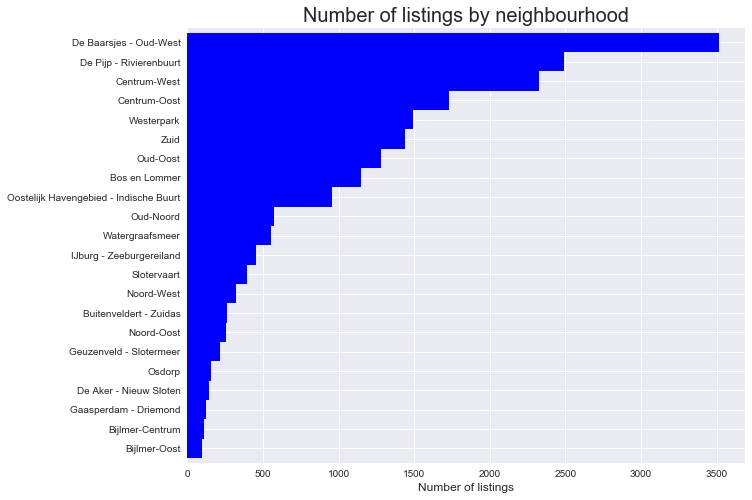

In [39]:
feq = listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color ='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel("Number of listings", fontsize=12)
plt.show()

In [102]:
lats2018 = listings['latitude'].tolist()[:20]
lats2018=[round(x,4) for x in lats2018]
lons2018 = listings['longitude'].tolist()[:20]
lons2018=[round(x,4) for x in lons2018]
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)
#FastMarkerCluster(data= [[52.3680, 4.9036],[52.3680, 4.9036],[52.4680, 4.9236],[52.3680, 4.9136]]).add_to(map1)
map1

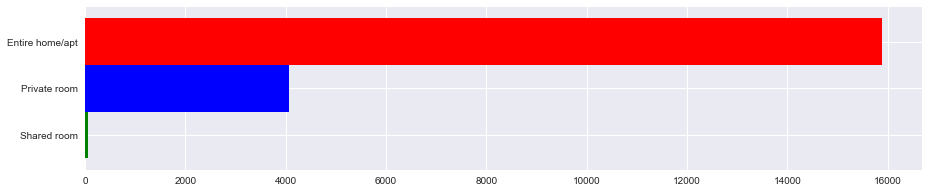

In [105]:
freq = listings['room_type'].value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15,3), width=1, color = ["g", "b", "r"])
plt.show()

In [106]:
listings.property_type.unique()

array(['Apartment', 'Townhouse', 'Houseboat', 'Bed and breakfast', 'Boat',
       'Guest suite', 'Loft', 'Serviced apartment', 'House',
       'Boutique hotel', 'Guesthouse', 'Other', 'Condominium', 'Chalet',
       'Nature lodge', 'Tiny house', 'Hotel', 'Villa', 'Cabin',
       'Lighthouse', 'Bungalow', 'Hostel', 'Cottage', 'Tent',
       'Earth house', 'Campsite', 'Castle', 'Camper/RV', 'Barn',
       'Casa particular (Cuba)', 'Aparthotel'], dtype=object)

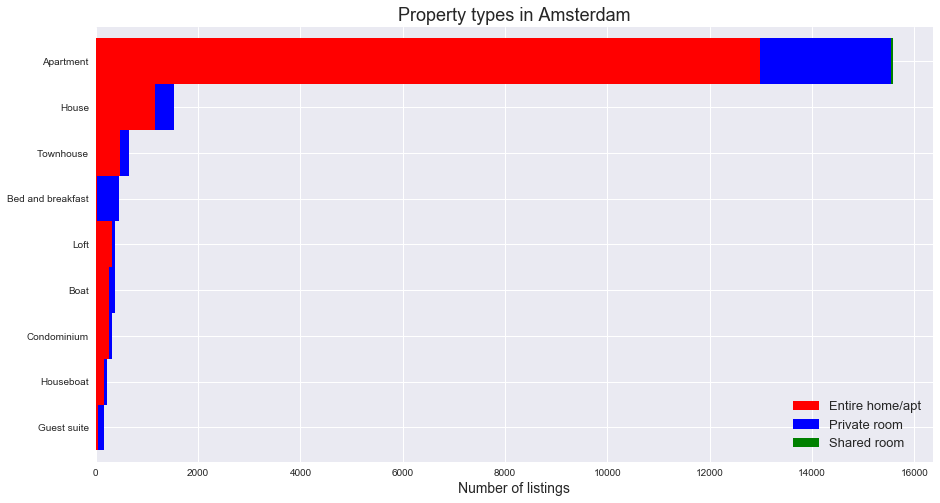

In [111]:
prop = listings.groupby(['property_type', 'room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:, 0:3].sum(axis=1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])


prop.plot(kind='barh', stacked=True, color = ["r", "b", "g"],
             linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Amsterdam', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc =4, prop={"size":13})
plt.rc('ytick', labelsize=13)
plt.show()

In [119]:
adam = gpd.read_file("neighbourhoods.csv")
feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map3 = folium.Map(location=[52.3680, 4.9036], zoom_start=11)
folium.GeoJson(data=adam,
               name='Amsterdam',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

KeyError: 'neighbourhood'

In [122]:
calendar = pd.read_csv("calendar.csv", parse_dates=['date'], index_col=['listing_id'])
calendar.price = calendar.price.str.replace(",","")
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$'))
calendar = calendar[calendar.date < '2019-12-05']
print(calendar.shape)



(7290073, 3)


(7290073, 3)

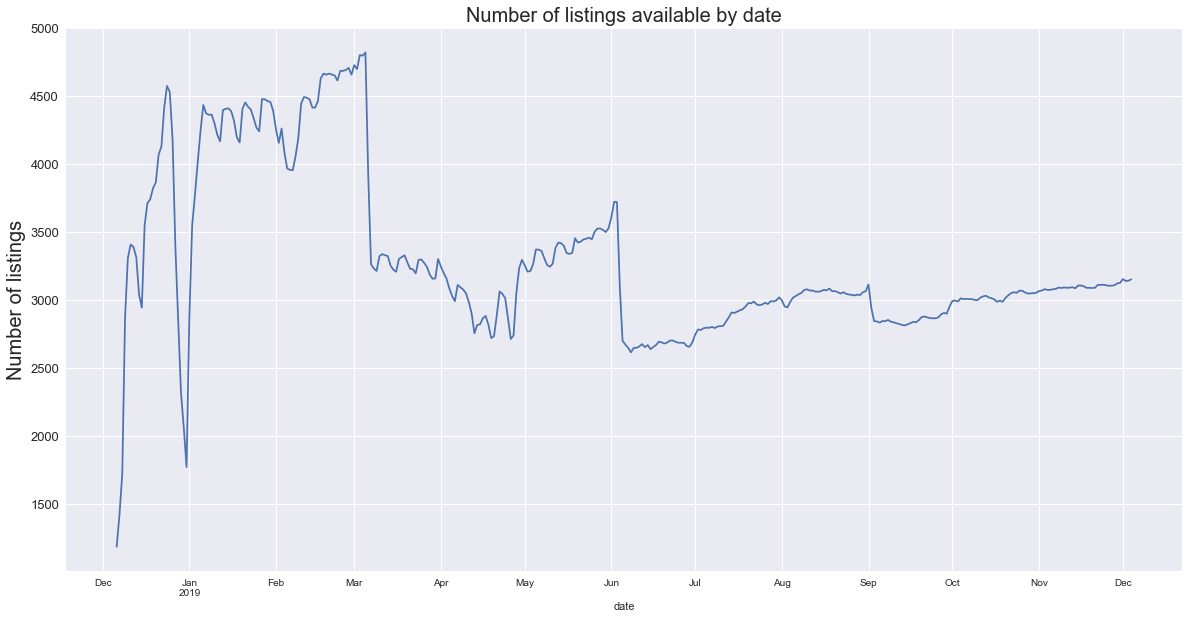

In [123]:
sum_available = calendar[calendar.available == "t"].groupby(['date']).size()
sum_available.plot(figsize=(20,10))
plt.title("Number of listings available by date", fontsize = 20)
plt.ylabel('Number of listings', fontsize=20)
plt.show()

